In [1]:
# Import the packages
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score
from sqlalchemy import create_engine


In [2]:
plt.style.use('dark_background')
#resize plot to wide form
plt.rcParams['figure.figsize'] = [20, 4]
#shrink plot labels
plt.rcParams.update({'font.size': 12})
#remove all boundaries
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
def bulk_insert(df, table_name, conn_string):
    conn = psycopg2.connect(conn_string)
    cur = conn.cursor()
    output = io.StringIO()
    df.to_csv(output, sep='\t', header=False, index=True)
    output.seek(0)
    cur.copy_from(output,table_name, null="")
    conn.commit()
    conn.close()


In [45]:
data_raw = pd.read_csv('island_banyan.csv', delimiter = ',')

#get data_raw length
data_raw_length = len(data_raw)

#get split index for train and test
split_index = int(data_raw_length*.8)
split_index, data_raw_length

(1728, 2160)

In [46]:
#set datatype to datetime for first column in data_raw
data_raw['time'] = pd.to_datetime(data_raw['time'])
data_raw.set_index('time', inplace=True)

#smooth data (averaging small cyclical changes like tide)
sm_len = 7
data_raw_sm = data_raw.rolling(sm_len).mean()

data_train = data_raw_sm.iloc[split_index-1700:(split_index)]
data_test = data_raw_sm.iloc[(split_index):]

print(data_train.shape)

(1700, 20)


In [ ]:
print(data_train.head())

## DB connection

In [48]:
## fill your db information
database = '' # FILL IN your db name where tspdb is installed
user = 'postgres' #  FILL IN  user name here
password = '00' #  # FILL IN  password here
host = 'localhost' #  # FILL IN  host name
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)
driver="postgresql"
engine = create_engine(driver + '://' + user + ':' + password + '@' + host + '/' + database)

## Create Time Series Table

In [60]:
conn = psycopg2.connect(conn_string)

cur = conn.cursor()

# Drop the table if it already exists
cur.execute("DROP table IF EXISTS island_banyan;")
conn.commit()
conn.close()

# load data into Pandas dataframe
data_train.to_sql('island_banyan', engine, index=True, index_label='time')
#data_train.to_csv('island_banyan_table.csv')
print('Table created and Loaded')

Table created and Loaded


In [ ]:
# lets query our table to inspect its column 
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from island_banyan order by time DESC limit 10;", conn)
conn.close()
df

## Create prediction index

In [61]:
# get all columns and format it
cols = '{"'+'","'.join(data_train.columns[:])+'"}'
query = """select create_pindex('island_banyan', 'time','%s','pindex_banyan', k=> 20);"""%cols
print('formated query : ',query )
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute(query)
conn.commit()
conn.close()

formated query :  select create_pindex('island_banyan', 'time','{"MT_001","MT_002","MT_003","MT_004","MT_005","MT_006","MT_007","MT_008","MT_009","MT_010","MT_011","MT_012","MT_013","MT_014","MT_015","MT_016","MT_017","MT_018","MT_019","MT_020"}','pindex_banyan', k=> 20);


In [62]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices()", conn)
df

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_5860/1280691254.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("select * from list_pindices()", conn)


,index_name,value_columns,relation,time_column,initial_timestamp,last_timestamp,agg_interval,uncertainty_quantification
0,pindex_isl1,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_1,time,1949-06-09 00:00:00,2020-07-13 00:00:00,24:00:00,True
1,mixturets_var_pindex,[ts],mixturets_var,time,0,99999,1 units,True
2,pindex_banyan,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_banyan,time,2017-06-29 00:00:00,2022-02-22 00:00:00,24:00:00,True
3,basic_pindex,[ts],ts_basic_ts_5_5,time,2012-10-01 00:00:00,2012-10-06 18:53:15,00:00:05,True
4,mixturets2_pindex,[ts],mixturets2,time,0,100000,1 units,True
5,pindex_e20,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_1,time,1949-06-09 00:00:00,2020-07-13 00:00:00,24:00:00,True
6,pindex_isl3,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_test_3,time,2019-12-21 00:00:00,2020-07-07 00:00:00,24:00:00,True
7,pindex_isl2,"[MT_001, MT_002, MT_003, MT_004, MT_005, MT_00...",island_banyan,time,2017-06-29 00:00:00,2022-02-22 00:00:00,24:00:00,True


## Prediction Queries

/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_5860/2780470985.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query('''select * from predict('island_banyan','MT_020','2022-02-22 00:00:00'\


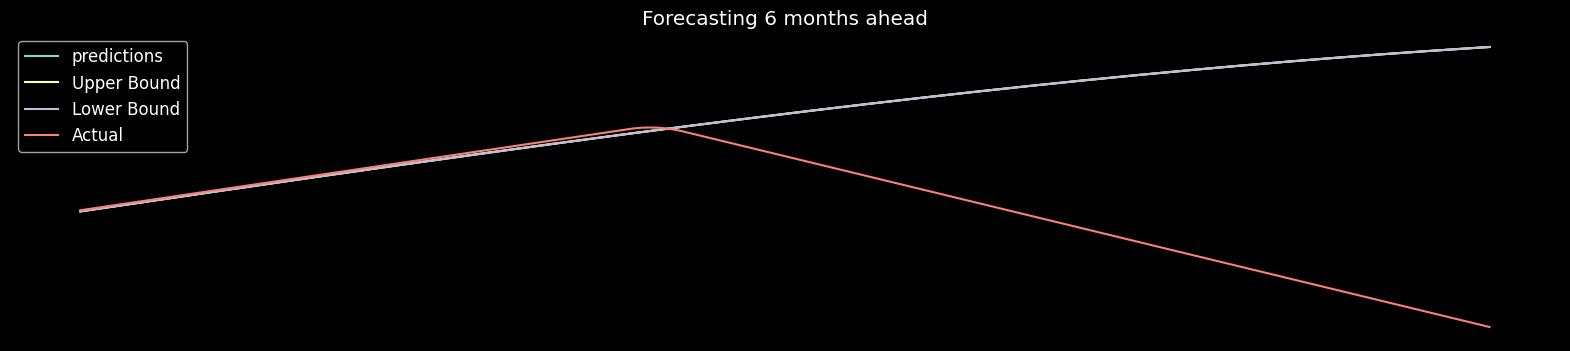

In [67]:
%matplotlib inline
df = pd.read_sql_query('''select * from predict('island_banyan','MT_020','2022-02-22 00:00:00'\
,'2022-08-22 00:00:00','pindex_banyan');''', conn)

plt.figure()
plt.plot( df['prediction'], label = 'predictions')
plt.plot( df['ub'], label = 'Upper Bound')
plt.plot(df['lb'], label = 'Lower Bound')
plt.plot(data_test['MT_020'].values[:len(df['prediction'])], label = 'Actual')
plt.title('Forecasting 6 months ahead')
plt.legend()
plt.show()

Let's calculate the error using the metric Weighted Absolute Percent Error (WAPE) which is calculated as:

$\text{WAPE} = \frac{\sum_i \sum_j |Y_{ij}-\hat{Y}_{ij}|} {\sum_i \sum_j |Y_{ij}|} $

Where:
- $Y_{ij}$ is the actual observation for time series j at time i 
- $\hat{Y}_{ij}$ is the predicted value for time series j at time i 

In [68]:
Y = data_test['MT_020'].values[:len(df['prediction'])]
Y_h = df['prediction']
wape = np.sum(np.abs(Y-Y_h))/np.sum(np.abs(Y))
print ('Forecasting accuracy (WAPE):',wape)

Forecasting accuracy (WAPE): 0.005766493416545694


In [70]:
# predict for 2 years
seasons = 4
s_len = 180

#initialise prediction array
predictions = np.zeros((len(data_test.columns),seasons*s_len))
ub = np.zeros((len(data_test.columns),seasons*s_len))
lb = np.zeros((len(data_test.columns),seasons*s_len))
actual = data_test.values[:seasons*s_len,:]
# specify start time
start_time = pd.Timestamp('2022-02-22 00:00:00')

for season in range(seasons):
    print('season: ',season+1)
    # get the final time stamp in the day
    end_time = start_time + pd.Timedelta(days=s_len-1)
    # convert timestamps to string
    start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
    end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
    print('starting from %s to  %s '%(start_str,end_str))
    # predict for each transect
    for i, column in enumerate(data_test.columns):
        #print('predicting column:%s for season %s '%(column,season+1))
        
        ## execute forecast query
        df_30 = pd.read_sql_query('''select * from predict('island_banyan','%s','%s'\
    ,'%s','pindex_isl1');'''%(column, start_str, end_str), conn)
        predictions[i,season*s_len:(season+1)*s_len] = df_30['prediction']
        ub[i,season*s_len:(season+1)*s_len] = df_30['ub']
        lb[i,season*s_len:(season+1)*s_len] = df_30['lb']
    # insert the already predicted values into the database
    df_insert = data_test.iloc[season*s_len:s_len*(season+1),:]
    bulk_insert(df_insert, 'island_banyan', conn_string)
    # update start_time
    start_time = start_time + pd.Timedelta(days=s_len)

season:  1
starting from 2022-02-22 00:00:00 to  2022-08-20 00:00:00 


/var/folders/9s/907qqv0j4yx8x_wljdzrslq80000gr/T/ipykernel_5860/1511546245.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_30 = pd.read_sql_query('''select * from predict('island_banyan','%s','%s'\


season:  2
starting from 2022-08-21 00:00:00 to  2023-02-16 00:00:00 
season:  3
starting from 2023-02-17 00:00:00 to  2023-08-15 00:00:00 
season:  4
starting from 2023-08-16 00:00:00 to  2024-02-11 00:00:00 


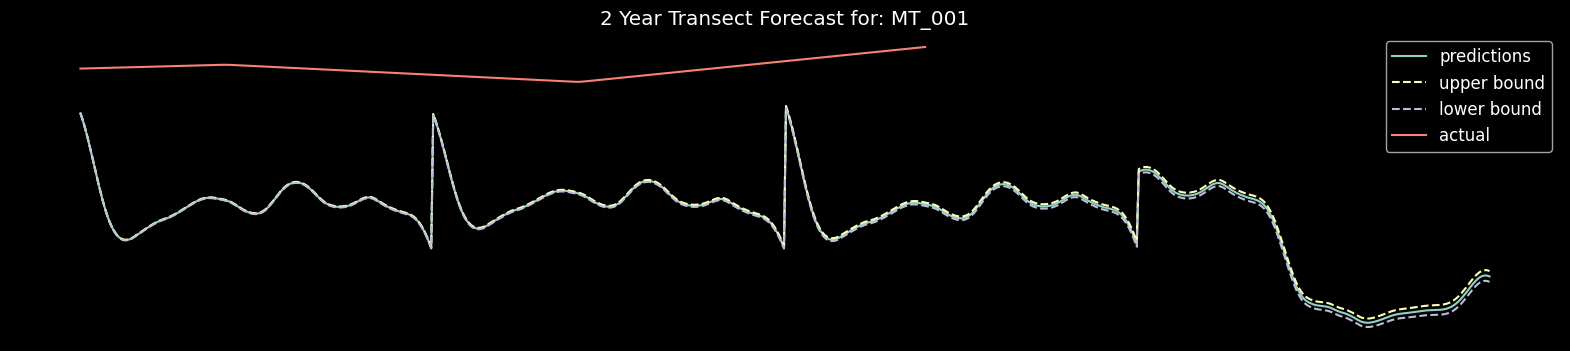

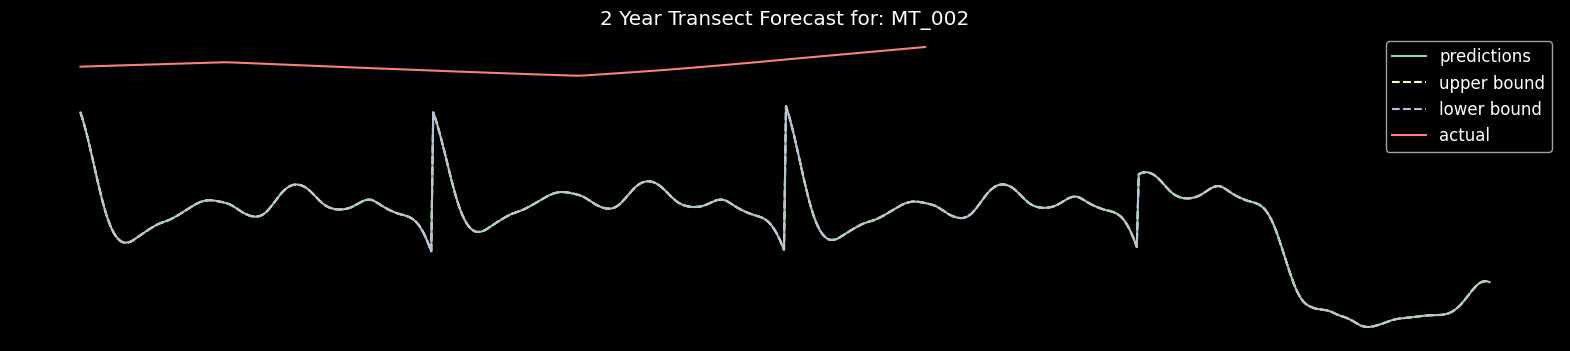

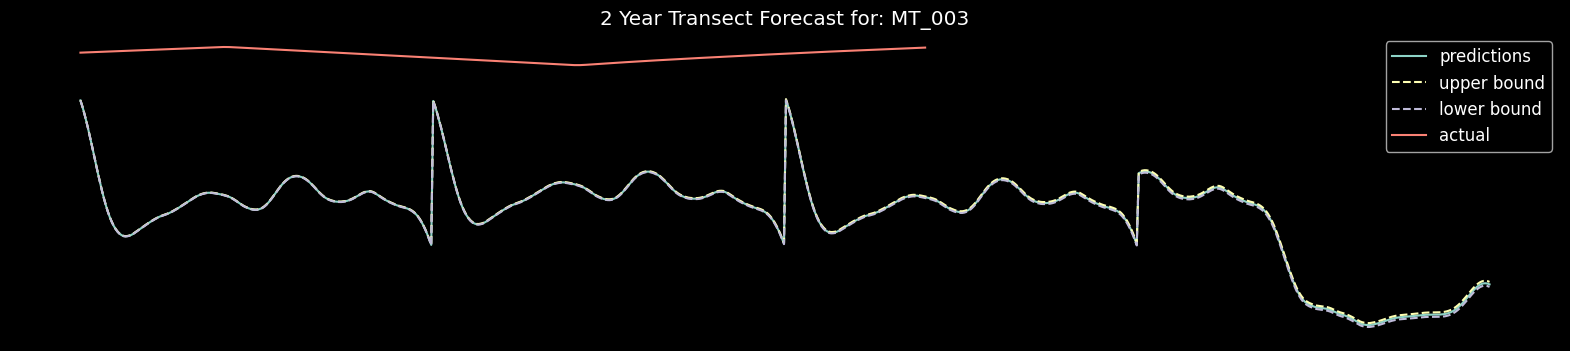

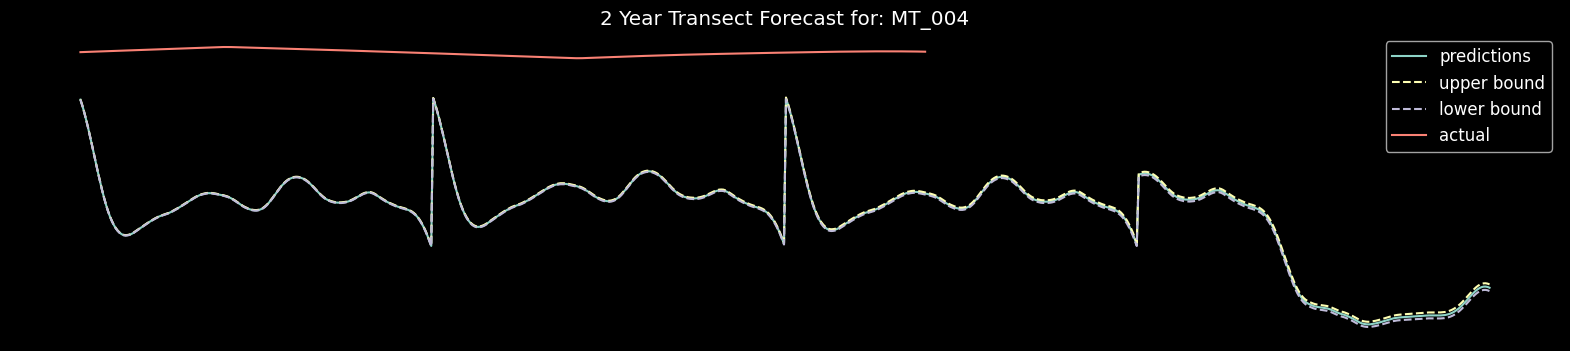

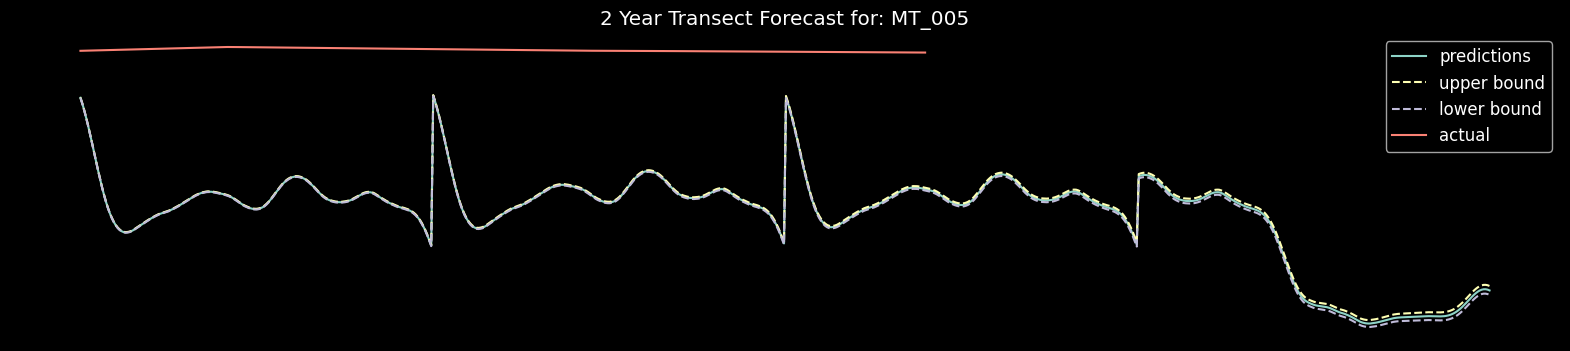

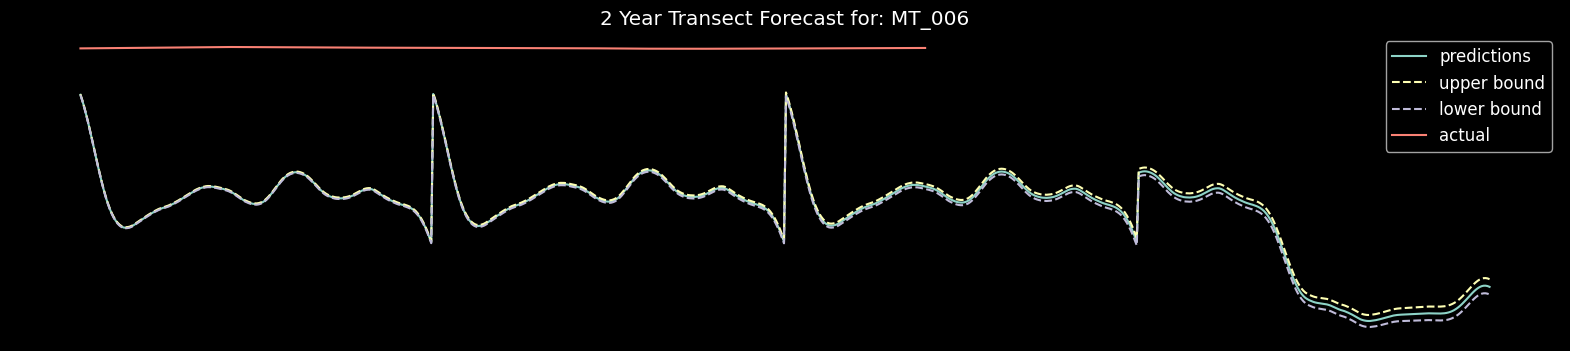

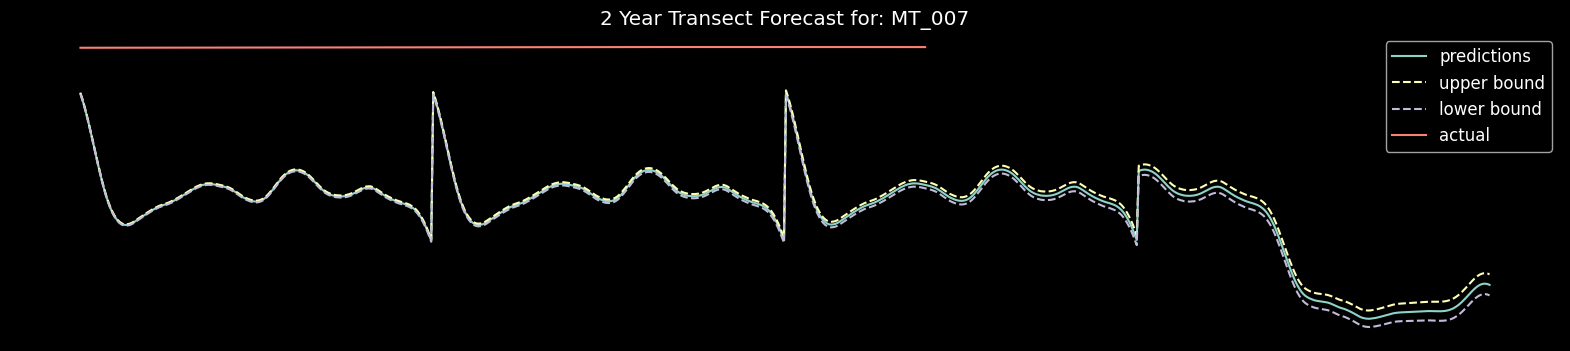

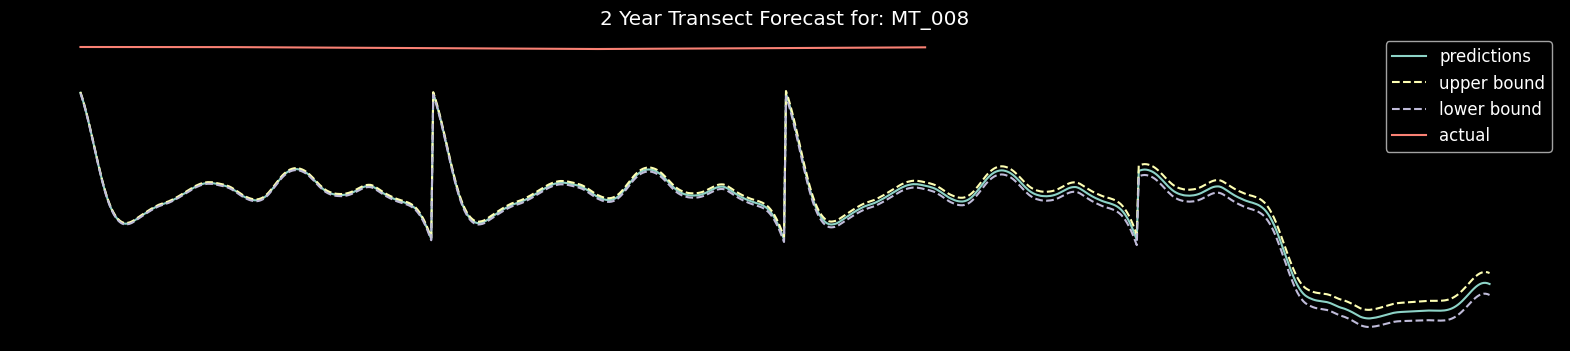

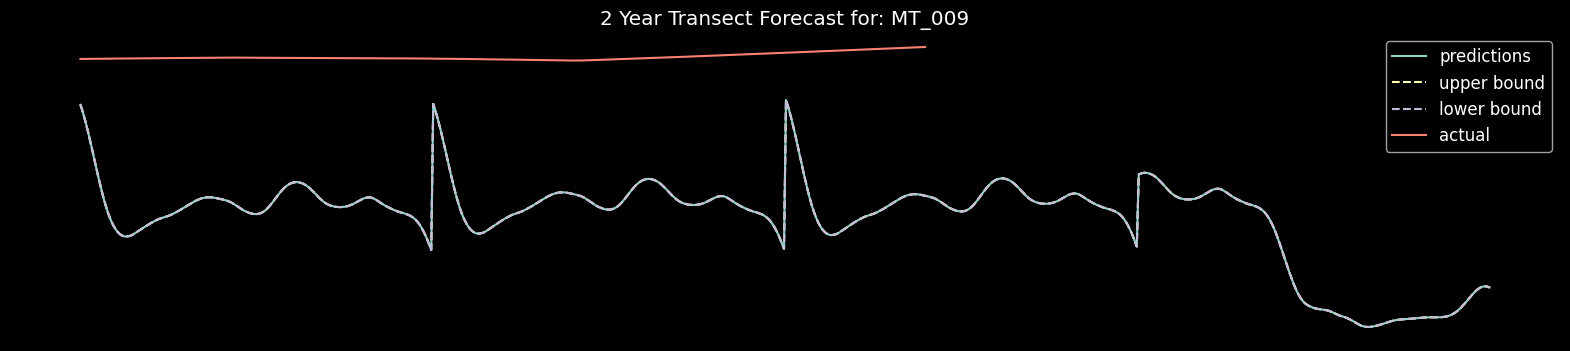

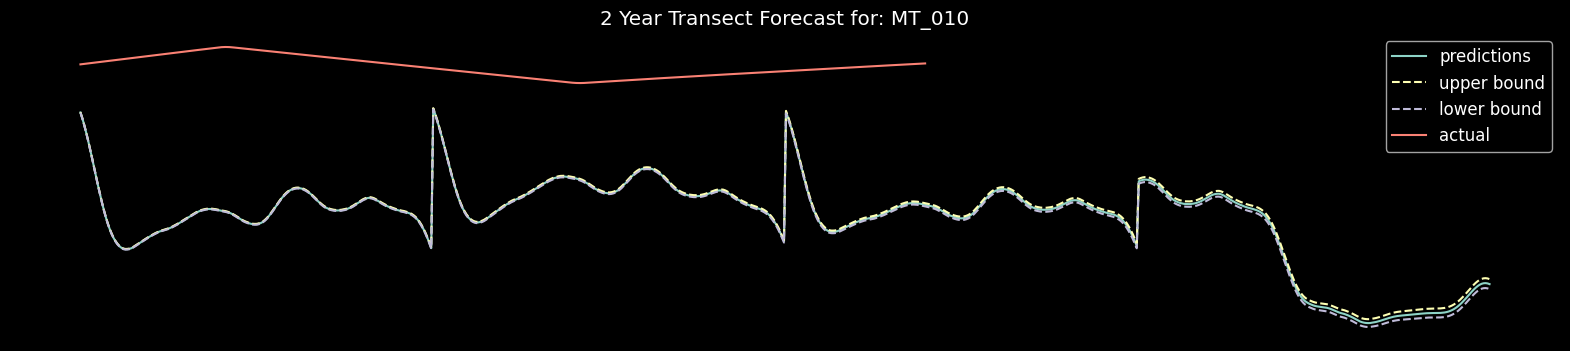

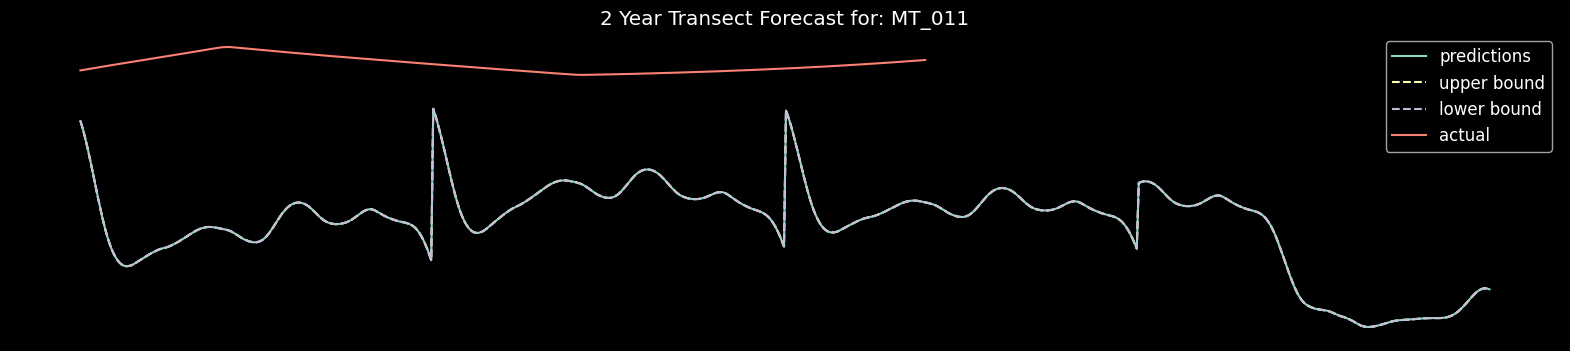

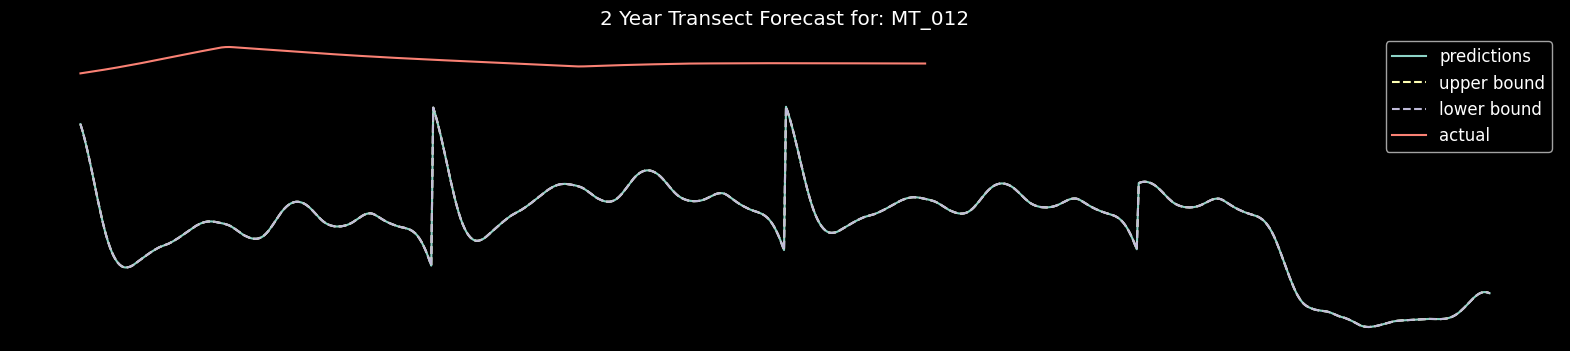

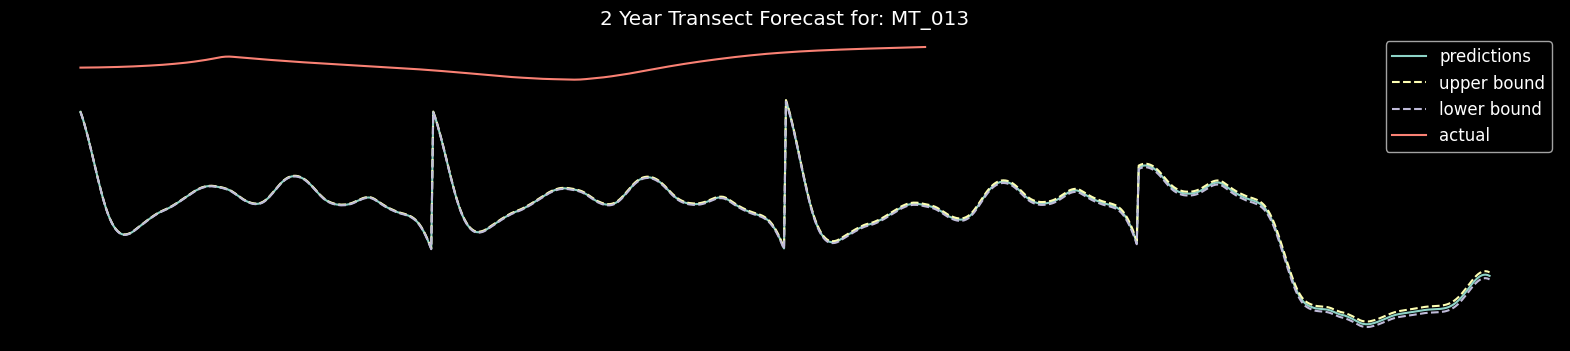

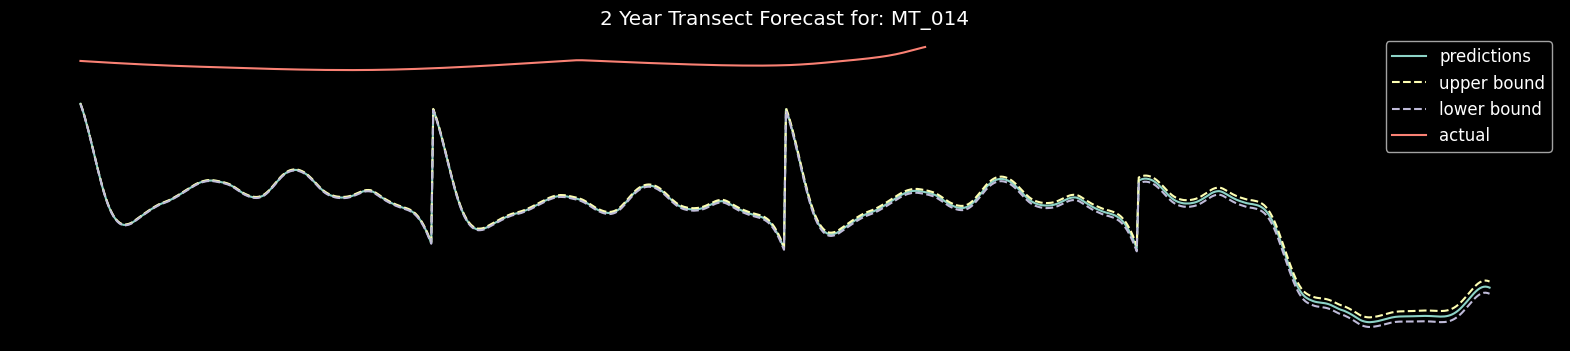

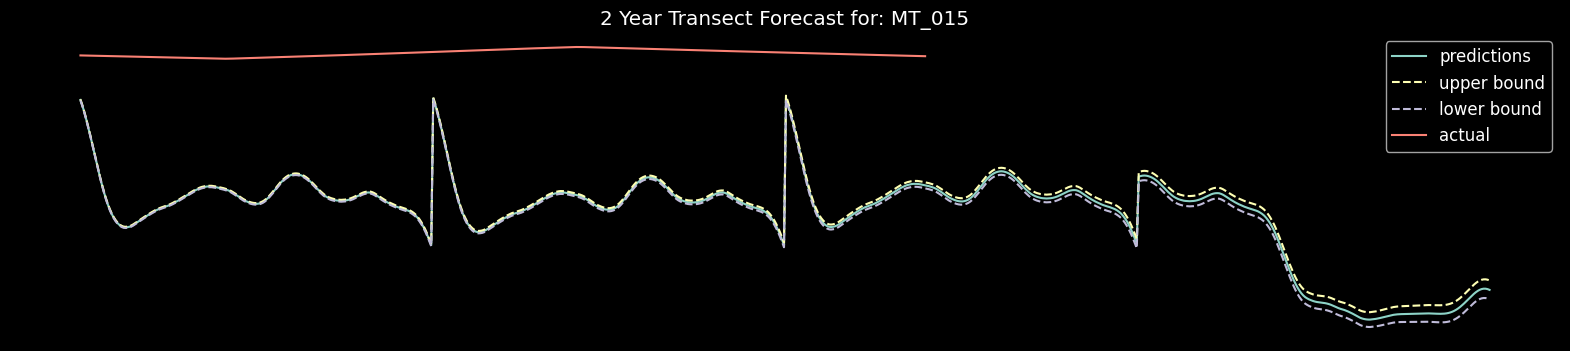

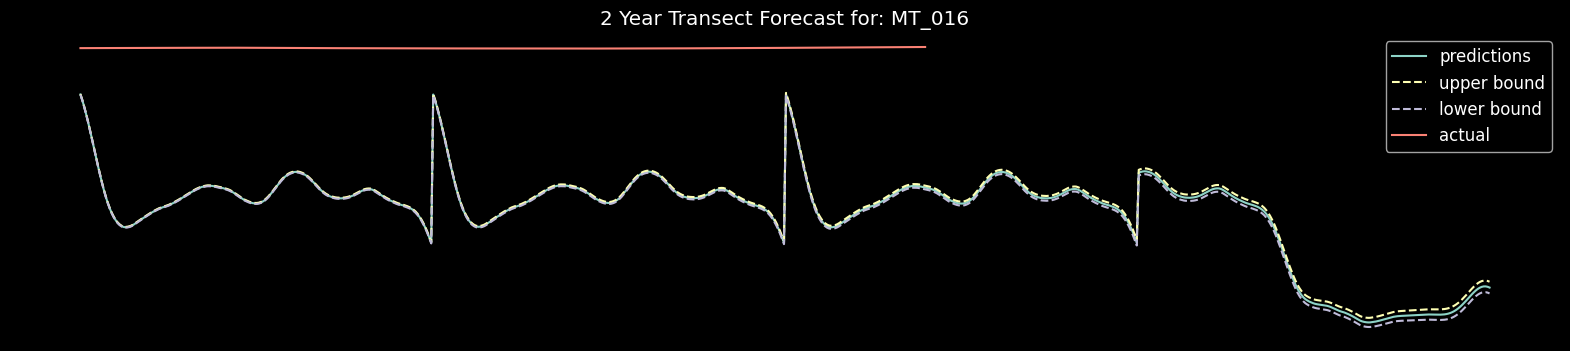

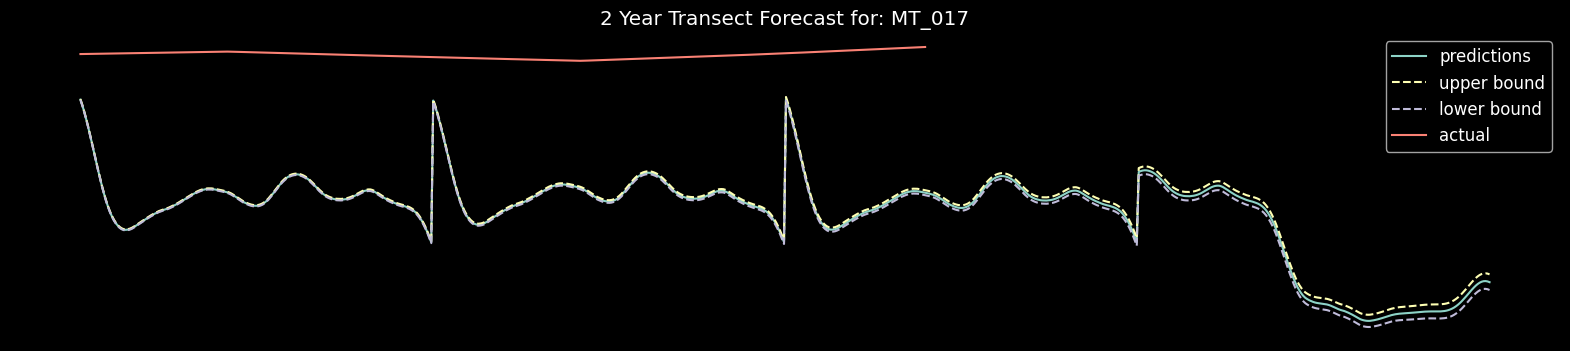

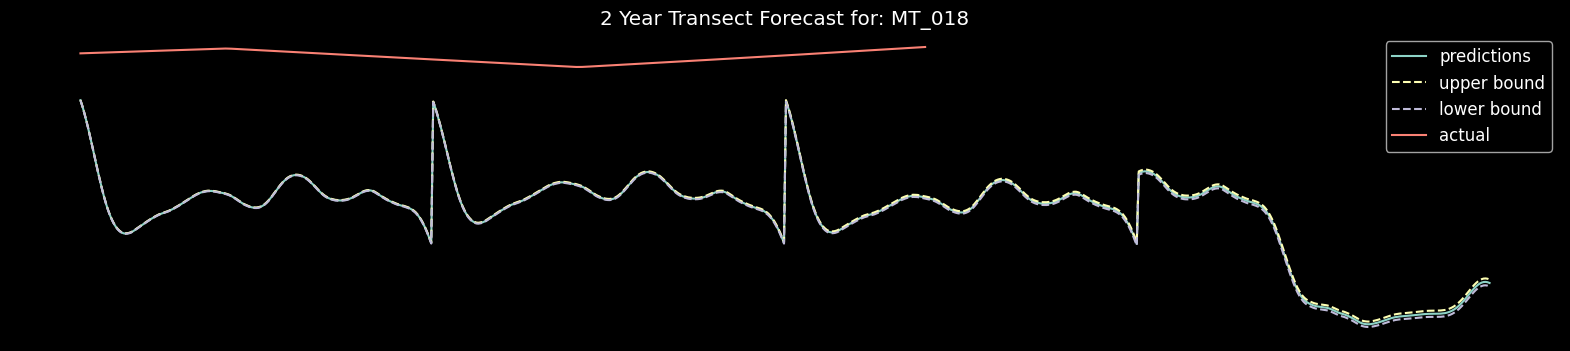

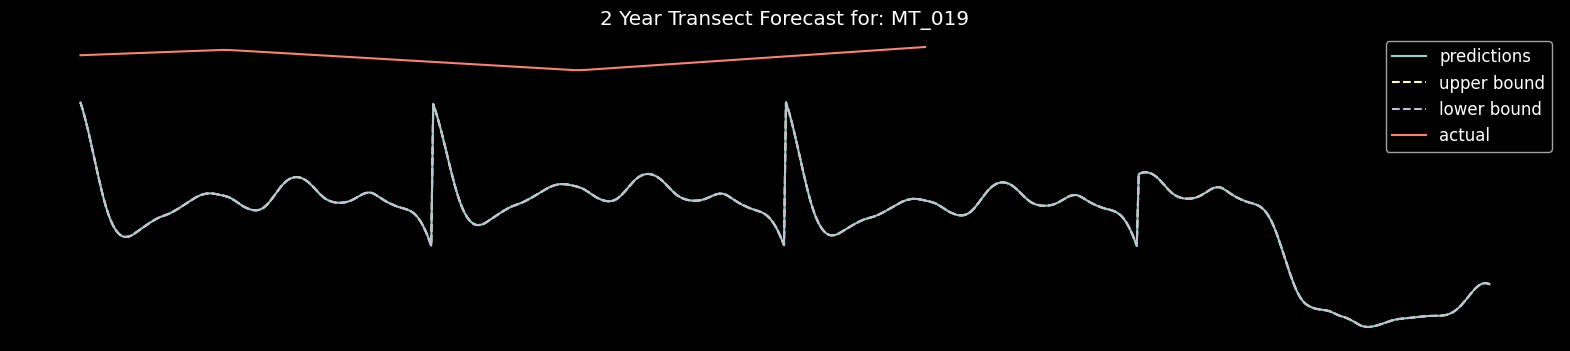

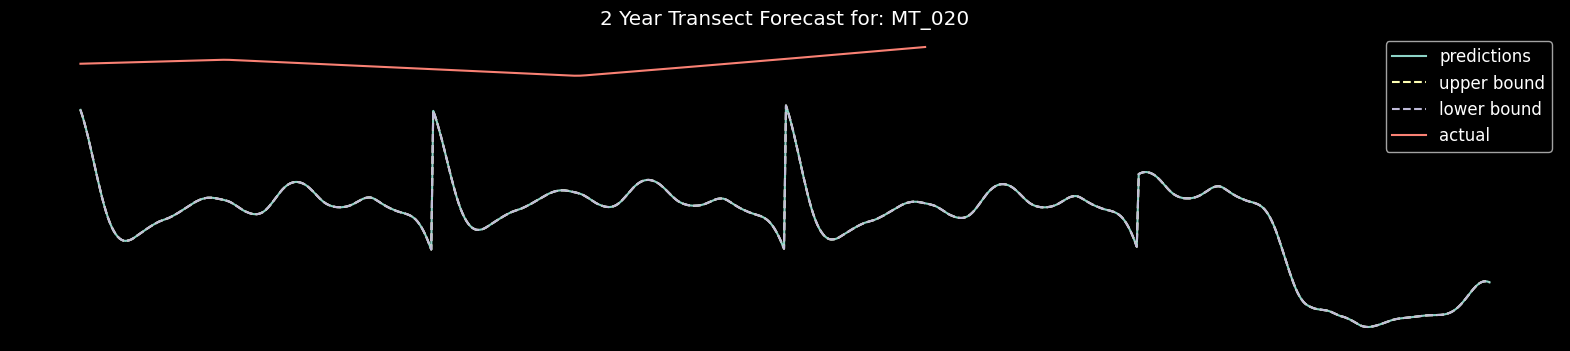

In [71]:
%matplotlib inline
for i in range(20):
    #hide x and y axis ticks
    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    #hide labels
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.labelleft'] = False

    plt.figure()
    plt.title('2 Year Transect Forecast for: %s'%data_test.columns[i])
    plt.plot(predictions[i,:seasons*s_len],label= 'predictions')
    plt.plot(ub[i,:seasons*s_len],'--',label= 'upper bound')
    plt.plot(lb[i,:seasons*s_len],'--',label= 'lower bound')
    plt.plot(actual[:seasons*s_len,i],label = 'actual')
    plt.legend()

plt.show()